### Electric Potential ###

We solve
numerically for the electric potential near a capacitor
using the Gauss-Seidel method for finite differences.

We solve the Laplace equation
$$\nabla^2 V({\bf x}) = \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial x^2} = 0,$$
on the domain $x\in\{x_{\rm min},x_{\rm max}\}$ and $y\in\{y_{\rm min},y_{\rm max}\}$,
with the boundary conditions
$$V({\bf x}_b) = 0$$
where ${\bf x}_b$ is a point on the boundary.
To solve this equation numerically, we construct a discrete, two-dimensional grid with $\{N_x, N_y\}$ points. The $x$-coordinate is defined by
$$x_i = x_{\rm min} + (i-1)\Delta x\qquad \mbox{for}\; i = 1, 2, \ldots, N_x$$
where
$$\Delta x = \frac{x_{\rm max} - x_{\rm min}}{N_x-1}$$
points. The $y$-coodrinate is defined similarly.

A finite difference approximation for the second derivative is
$$
\frac{\partial^2 V}{\partial x^2} = \frac{V_{i+1,j} - 2V_{i,j}+V_{i-1,j}}{\Delta x^2} + {\rm O}(\Delta x^2).
$$
The term ${\rm O}(\Delta x^2)$ represents the leading order error term in this approximation, indicating that this error is proportional to $\Delta x^2$.  So if
$\Delta x$ decreases by a factor of 10, then the error in the finite difference
approximation for the derivative decreases by a factor of $100$.

The finite difference approximation for the Laplace equation is
$$\frac{V_{i+1,j} - 2V_{i,j}+V_{i-1,j}}{\Delta x^2}
+ \frac{V_{i,j+1} - 2V_{i,j}+V_{i,j-1}}{\Delta y^2} = 0.$$
We can solve this equation for $V_{ij}$, giving
\begin{equation}
V_{ij} = \frac{1}{4}\left(V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1}\right).
\end{equation}
This is a linear system of equations, which would require solving a matrix system
for a direction solution.  However, one easy method of solving this system is
to make an initial guess everywere for $V_{ij}$, and then simply iterate on the equation above.  This is the Jacobi iteration method. Technically, we choose the Gauss-Seidel method, which uses updated information in the Jacobi iteration, as it is a little faster.  You can read about both methods on Wikipedia.

This implementation requires boundary conditions on the outer boundary, but also allows the user to specify boundary conditions in the interior of the domain.  So, for example, we could place a capacitor in the domain.  This implementation of Gauss-Seidel iteration uses a `mask` function, which indicates whether the potential at that specific point is fixed or not.  If `mask[i,j]==1` at a point, then the potential is fixed and not allowed to vary.  If `mask[i,j]==0`, then the potential at the point varies as a solution of $\nabla^2 V = 0$.

In [1]:
using Plots

In [2]:
#= This function initializes the potential for a finite capacitor.
The capacitor plates have potential Vp and Vm, with locations given by a set of 
parameters.  The mask is also initialized.  Where mask==1, the potential is 
fixed.
=#

function initFiniteCapacitor!(V, mask, x, y)
    nx, ny = size(V)
    xploc = 1.0
    xmloc = -1.0
    ymin = -4.0
    ymax = 4.0
    Vp = 100.0
    Vm = -100.0
    Vb = 0.0
    V0 = 1.0
    dx = x[2] - x[1]
    
    for j = 1:ny
        for i = 1:nx
            V[i,j] = V0
            mask[i,j] = 0
            if i==1 || j==1 || i ==nx || j==ny
                V[i,j] = Vb
                mask[i,j] = 1
            end
            if ymin < y[j] && y[j] < ymax
                if xploc-dx < x[i] && xploc+dx > x[i]
                    V[i,j] = Vp
                    mask[i,j] = 1
                elseif xmloc-dx < x[i] && xmloc+dx > x[i]
                    V[i,j] = Vm
                    mask[i,j] = 1
                end
            end
        end
    end
end

initFiniteCapacitor! (generic function with 1 method)

In [3]:
# This function defines coordinate arrays.  
# The coordinate x ranges from xmin to xmax with n points.

function defineCoords(n, xmin, xmax)
    x = Array{Float64}(undef,n)
    dx = (xmax - xmin)/(n-1)
    for i = 1:n
        x[i] = xmin + (i-1)*dx
    end
    return x
end

defineCoords (generic function with 1 method)

In [4]:
#= This function performs the Gauss-Seidel iteration until either changes in the 
solution drop below a given tolerance, tol, or the maximum number of iterations,
maxSteps is reached.
=#

function GaussSeidel!(V,mask,tol,maxSteps,h)

    nx, ny = size(V)
    step = 0
    
    err = 2.0*tol
    
    while (step < maxSteps && err > tol)
        #print("begin loop, tol=",tol)
        errsum = 0.0
        for j = 2:ny-1
            for i = 2:nx-1
                if mask[i,j] < 1
                    Vnew = 0.25*(V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])
                    errsum += (Vnew - V[i,j])^2
                    V[i,j] = Vnew
                end
            end
        end
        err = errsum*h^2
        step += 1
        #println("Step ",step,", Err ",err)
    end
 
   return step, err
end
                

GaussSeidel! (generic function with 1 method)

In [35]:
#=
#  This routine solves the Laplace equation with Successive Over Relaxation.
#  It also performs the update with a Red-Black ordering of grid points.
#  It is much faster than Gauss-Seidel iteration.
=#
function SOR!(V,omega,mask,tol,maxSteps,h)

    nx, ny = size(V)
    step = 0
    
    err = 2.0*tol
    
    while (step < maxSteps && err > tol)
        #print("begin loop, tol=",tol)
        errsum = 0.0
        for phase = 0:1
            for j = 2:ny-1
                ibgn = 1 + mod(j,2) + phase
                for i = ibgn:2:nx-1
                    if mask[i,j] < 1
                        Res = 0.25*(V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1]- 4.0*V[i,j])
                        errsum += (omega*Res)^2
                        V[i,j] = V[i,j] + omega*Res
                    end
                end
            end
        end
        err = errsum*h^2
        step += 1
    end
 
   return step, err
end

SOR! (generic function with 1 method)

In [36]:
function solver(shp, bbox, tol, maxit)
    nx = shp[1]
    ny = shp[2]
    mask = Array{Int64,2}(undef,nx,ny)
    V = Array{Float64,2}(undef,nx,ny)
    x = defineCoords(nx, bbox[1], bbox[2])
    y = defineCoords(ny, bbox[3], bbox[4])
    h = x[2]-x[1]
    initFiniteCapacitor!(V, mask, x, y)
    #step, err = GaussSeidel!(V, mask, tol, maxit,h)
    omega = 1.5
    step, err = SOR!(V, omega, mask, tol, maxit,h)
    println("Solution finished. step=",step,", err=",err,", tol=",tol)
    return V, mask, err
end

solver (generic function with 1 method)

In [43]:
shp = Int64[401, 401]
bbox = Float64[-10.0,10.0,-10.0,10.0]
tol = 1.0e-4
maxstep = 6000
V, mask, err = solver(shp, bbox, tol, maxstep);

Solution finished. step=5939, err=9.999064416734881e-5, tol=0.0001


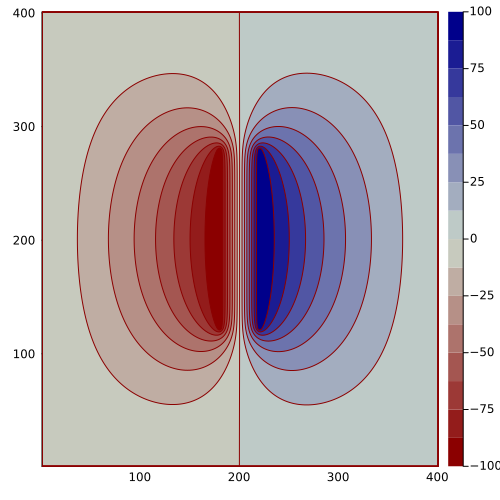

In [44]:
contourf(V',c=:redsblues,size=(500,500))